# **RNN (LSTM) Model for Human Action Recognition**

___
___

## **1. INITIALIZATION**

### *1.1. IMPORT*

In [1]:
from IPython.display import display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random as rd
import time

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import torch
import torch.nn as nn

In [2]:
# to fill the requirement.txt file we use the following line of code:
import session_info
session_info.show()

In [3]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device: {}".format(device))

device: cuda


### *1.2. DATA LOADING*

In [4]:
data_dir = "../data/nturgbd_skeletons_cleaned/"
data_files = os.listdir(data_dir)

In [5]:
with open("../data/actions.txt", 'r') as actions_file:
    actions = [line.replace('\n', '') for line in actions_file.readlines()]
    actions_file.close()

In [6]:
classes = [5, 6, 7, 8, 14, 24, 30, 32, 42]
for i,elem in enumerate(classes):
    print("class {} : {}".format(i, actions[elem]))

class 0 : pickup
class 1 : throw
class 2 : sitting down
class 3 : standing up (from sitting position)
class 4 : take off jacket
class 5 : reach into pocket
class 6 : pointing to something with finger
class 7 : check time (from watch)
class 8 : falling


In [7]:
class HumanActionDataset(Dataset):

    def __init__(self, data_dir, data_files, classes):
        self.data_dir = data_dir
        self.data_files = []
        for data_file in data_files:
            if int(data_file[17:-4])-1 in classes:
                self.data_files = self.data_files + [data_file]
        self.classes = classes

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        tensor = torch.Tensor(np.load(self.data_dir + self.data_files[idx]))
        tensor = tensor.reshape((tensor.shape[0], 75))
        label = int(self.data_files[idx][17:-4])-1
        label = self.classes.index(label)
        return (tensor, label)

We also build a dataset in which we are going to mask some joints to see if our model is robust enough to missing data.

In [8]:
class HumanActionDataset_Masked(Dataset):

    def __init__(self, data_dir, data_files, classes, percentage):
        self.data_dir = data_dir
        self.data_files = []
        self.percentage = percentage
        for data_file in data_files:
            if int(data_file[17:-4])-1 in classes:
                self.data_files = self.data_files + [data_file]
        self.classes = classes

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        tensor = torch.Tensor(np.load(self.data_dir + self.data_files[idx]))
        tensor = tensor.reshape((tensor.shape[0], 75))
        label = int(self.data_files[idx][17:-4])-1
        label = self.classes.index(label)
        joints_to_hide = rd.sample(range(25), int(25*self.percentage))
        for joint_to_hide in joints_to_hide:
            for i in range(tensor.shape[0]):
                tensor[i][joint_to_hide*3:joint_to_hide*3+3] = -10 # all values are above -3 normally
        return (tensor, label)

Here we are going to use PyTorch’s DataLoader with Variable Length Sequences for LSTM/GRU : from this [article](https://www.codefull.net/2018/11/use-pytorchs-dataloader-with-variable-length-sequences-for-lstm-gru/).

In [9]:
class PadSequence():

    def __call__(self, batch):

        # let's assume that each element in "batch" is a tuple (data, label).
        # the following line of code sort the batch in the descending order
        sorted_batch = sorted(batch, key=lambda x: x[0].shape[0], reverse=True)
        
        # then we take each sequence of the batch and pad it
        sequences = [x[0] for x in sorted_batch]
        sequences_padded_end = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)

        lengths = torch.LongTensor([len(x) for x in sequences])

        # here we adjust the padding because we want zeros at the beginning
        # (we had poor results with zeros at the end)
        sequences_padded_begin = torch.stack(
            [torch.cat([
                sequences_padded_end[i][lengths[i]:],
                sequences_padded_end[i][:lengths[i]]]
            ) for i in range(len(sequences_padded_end))]
        )

        # don't forget to grab the labels of the *sorted* batch
        labels = torch.LongTensor([x[1] for x in sorted_batch])
        return sequences_padded_begin, lengths, labels

In [12]:
HAD = HumanActionDataset(data_dir, data_files, classes)

In [13]:
HAD_masked = HumanActionDataset_Masked(data_dir, data_files, classes, 0.2)


We use 80% of the data for training and the remaining 20% for validation.

In [14]:
train_dataset, val_dataset = torch.utils.data.random_split(HAD, [int(0.80*len(HAD)), len(HAD)-int(0.80*len(HAD))])

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, collate_fn=PadSequence(), shuffle=True)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32, collate_fn=PadSequence(), shuffle=True)

In [15]:
train_dataset_masked, val_dataset_masked = torch.utils.data.random_split(HAD_masked, [int(0.80*len(HAD_masked)), len(HAD_masked)-int(0.80*len(HAD_masked))])

train_dataloader_masked = torch.utils.data.DataLoader(dataset=train_dataset_masked, batch_size=32, collate_fn=PadSequence(), shuffle=True)
val_dataloader_masked = torch.utils.data.DataLoader(dataset=val_dataset_masked, batch_size=32, collate_fn=PadSequence(), shuffle=True)

### *1.3 AUXILIARY FUNCTIONS*

In [28]:
def train_model(model, criterion, optimizer, nb_epochs, epoch_print_frequence, train_dataloader, val_dataloader):

    s = time.time()

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(nb_epochs):

        running_loss_train, running_loss_val, running_acc_train, running_acc_val = 0, 0, 0, 0

        for train in [True, False]:

            if train:
                dataloader = train_dataloader
                model.train()
            else:
                dataloader = val_dataloader
                model.eval()

            for data in dataloader:
                
                inputs = data[0].to(device)
                labels_raw = data[-1]
                labels = torch.zeros((inputs.shape[0], len(classes)))
                for i in range(len(labels_raw)):
                    labels[i][int(labels_raw[i])] = 1
                labels = labels.to(device)

                if train:
                    optimizer.zero_grad()

                outputs_for_loss = model(inputs)
                sm = nn.Softmax(dim=1).to(device)
                outputs = sm(outputs_for_loss)
                outputs = outputs.to(device)
                loss = criterion(outputs_for_loss, labels)

                if train:
                    loss.backward()
                    optimizer.step()
                    running_loss_train += loss.item()
                    running_acc_train += int(torch.sum(outputs.argmax(dim=1) == labels.argmax(dim=1)))
                else:
                    running_loss_val += loss.item()
                    running_acc_val += int(torch.sum(outputs.argmax(dim=1) == labels.argmax(dim=1)))

        running_loss_train /= len(train_dataloader)
        running_loss_val /= len(val_dataloader)
        running_acc_train /= len(train_dataset)
        running_acc_val /= len(val_dataset)

        train_losses.append(running_loss_train)
        val_losses.append(running_loss_val)
        train_accs.append(running_acc_train)
        val_accs.append(running_acc_val)

        if (epoch+1) % epoch_print_frequence == 0:
            print("epochs {} ({} s) | train loss : {} | val loss : {} | train acc : {} | val acc : {}".format(
                epoch+1,
                int(time.time()-s),
                int(1000000*running_loss_train)/1000000,
                int(1000000*running_loss_val)/1000000,
                int(1000000*running_acc_train)/1000000,
                int(1000000*running_acc_val)/1000000
            ))
    
    return train_losses, val_losses, train_accs, val_accs

___

## **2. THE MODEL**

### *2.1. Definition*

In [29]:
class LSTM0(nn.Module):

    def __init__(self, nb_classes, input_size, hidden_size_lstm, hidden_size_classifier, num_layers, device):

        super(LSTM0, self).__init__()

        self.num_classes = nb_classes   # number of classes
        self.num_layers = num_layers    # number of layers
        self.input_size = input_size    # input size
        self.hidden_size = hidden_size_lstm  # hidden state
        self.device = device

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size_lstm, num_layers=num_layers, batch_first=True) # lstm
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size_lstm, hidden_size_classifier),
            nn.ReLU(),
            nn.Linear(hidden_size_classifier, nb_classes)
        )

    def forward(self,x):

        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device) # hidden state (short memory)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device) # internal state (long memory)
        
        _, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size) # reshaping the data for clasifier
        return self.classifier(hn)

### *2.2. Training*

#### *2.2.A On Full Data*

In [30]:
model_LSTM0 = LSTM0(nb_classes=len(classes), input_size=75, hidden_size_lstm=256, hidden_size_classifier=128, num_layers=1, device=device)
model_LSTM0.to(device)
model_LSTM0.eval()

LSTM0(
  (lstm): LSTM(75, 256, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=9, bias=True)
  )
)

In [35]:
criterion_LSTM0 = nn.CrossEntropyLoss()
optimizer_LSTM0 = torch.optim.Adam(params=model_LSTM0.parameters(), lr=1e-4)
lr_scheduler_LSTM0 = torch.optim.lr_scheduler.StepLR(optimizer_LSTM0, step_size=10, gamma=0.1)
nb_epochs = 100
epoch_print_frequence = 10

Let's train and save this first model and see the evolution of the loss and accuracy over the epochs.

In [36]:
losses_accs_LSTM0 = train_model(model_LSTM0, criterion_LSTM0, optimizer_LSTM0, nb_epochs, epoch_print_frequence, train_dataloader, val_dataloader)
torch.save(model_LSTM0.state_dict(), "../models_saved/LSTM0.pt")

epochs 10 (94 s) | train loss : 0.389337 | val loss : 0.423673 | train acc : 0.86687 | val acc : 0.855569
epochs 20 (199 s) | train loss : 0.268424 | val loss : 0.358117 | train acc : 0.907421 | val acc : 0.880048
epochs 30 (308 s) | train loss : 0.211035 | val loss : 0.322176 | train acc : 0.925325 | val acc : 0.88678
epochs 40 (418 s) | train loss : 0.167151 | val loss : 0.27349 | train acc : 0.936801 | val acc : 0.91432
epochs 50 (527 s) | train loss : 0.117371 | val loss : 0.265604 | train acc : 0.957918 | val acc : 0.90514
epochs 60 (637 s) | train loss : 0.119398 | val loss : 0.228579 | train acc : 0.960826 | val acc : 0.9235
epochs 70 (746 s) | train loss : 0.080874 | val loss : 0.268564 | train acc : 0.971384 | val acc : 0.913096
epochs 80 (861 s) | train loss : 0.075997 | val loss : 0.306517 | train acc : 0.973221 | val acc : 0.918604
epochs 90 (992 s) | train loss : 0.042862 | val loss : 0.256967 | train acc : 0.984238 | val acc : 0.914932
epochs 100 (1127 s) | train loss : 0

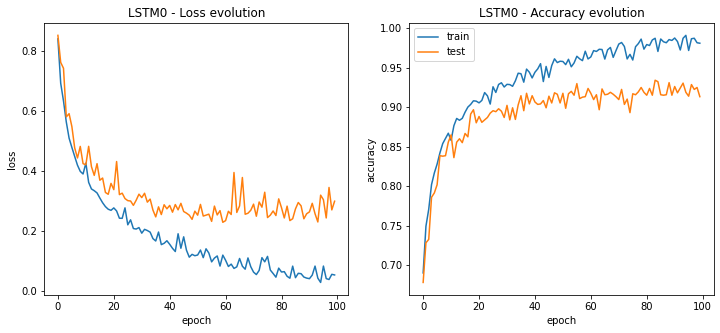

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

ax[0].set(title="LSTM0 - Loss evolution")
ax[0].plot(losses_accs_LSTM0[0], label="train")
ax[0].plot(losses_accs_LSTM0[1], label="test")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")

ax[1].set(title="LSTM0 - Accuracy evolution")
ax[1].plot(losses_accs_LSTM0[2], label="train")
ax[1].plot(losses_accs_LSTM0[3], label="test")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")

plt.legend()
plt.show()

One of the runs on 100 epochs:

![LSTM0 loss and accuracy evolution](../models_saved/LSTM0_loss_acc.jpeg)

Given that the model is quite simple, the results are encouraging.

For a better visualization, let's train the model multiple times and plot the average loss and accuracy evolutions.

***Remark*** *I stopped the process because my laptop strated to make a lot of noise.*

***TODO:*** *I'll launch the next cells (along with grid search) in a PC from the school.*

In [13]:
losses_accs = []

for i in range(4):

    print("STEP {}/4".format(i+1))

    model_LSTM0_i = LSTM0(nb_classes=len(classes), input_size=75, hidden_size_lstm=256, hidden_size_classifier=128, num_layers=1, device=device)
    model_LSTM0_i.to(device)
    model_LSTM0_i.eval()

    criterion_LSTM0_i = nn.CrossEntropyLoss()
    optimizer_LSTM0_i = torch.optim.Adam(params=model_LSTM0_i.parameters(), lr=1e-4)
    lr_scheduler_LSTM0_i = torch.optim.lr_scheduler.StepLR(optimizer_LSTM0_i, step_size=10, gamma=0.1)
    nb_epochs_i = 100
    epoch_print_frequence_i = 100

    losses_accs_LSTM0_i = train_model(model_LSTM0_i, criterion_LSTM0_i, optimizer_LSTM0_i, nb_epochs_i, epoch_print_frequence_i, train_dataloader, val_dataloader)
    losses_accs.append(losses_accs_LSTM0_i)

STEP 1/4


KeyboardInterrupt: 

In [ ]:
losses_accs_LSTM0_avg = []
losses_accs_LSTM0_avg.append([sum([elem[0][i] for elem in losses_accs])/4 for i in range(len(losses_accs[0][0]))])
losses_accs_LSTM0_avg.append([sum([elem[1][i] for elem in losses_accs])/4 for i in range(len(losses_accs[0][1]))])
losses_accs_LSTM0_avg.append([sum([elem[2][i] for elem in losses_accs])/4 for i in range(len(losses_accs[0][2]))])
losses_accs_LSTM0_avg.append([sum([elem[3][i] for elem in losses_accs])/4 for i in range(len(losses_accs[0][3]))])

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

ax[0].set(title="LSTM0 - (Average) Loss evolution")
ax[0].plot(losses_accs_LSTM0_avg[0], label="train")
ax[0].plot(losses_accs_LSTM0_avg[1], label="test")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")

ax[1].set(title="LSTM0 - (Average) Accuracy evolution")
ax[1].plot(losses_accs_LSTM0_avg[2], label="train")
ax[1].plot(losses_accs_LSTM0_avg[3], label="test")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")

plt.legend()
plt.show()

#### *2.2.B On Masked Data*

In [22]:
model_LSTM0_masked = LSTM0(nb_classes=len(classes), input_size=75, hidden_size_lstm=256, hidden_size_classifier=128, num_layers=1, device=device)
model_LSTM0_masked.to(device)
model_LSTM0_masked.eval()

LSTM0(
  (lstm): LSTM(75, 256, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=9, bias=True)
    (3): Softmax(dim=1)
  )
)

In [25]:
criterion_LSTM0_masked = nn.CrossEntropyLoss()
optimizer_LSTM0_masked = torch.optim.Adam(params=model_LSTM0_masked.parameters(), lr=1e-4)
lr_scheduler_LSTM0_masked = torch.optim.lr_scheduler.StepLR(optimizer_LSTM0_masked, step_size=10, gamma=0.1)
nb_epochs_masked = 80
epoch_print_frequence_masked = 10

In [26]:
losses_accs_LSTM0_masked = train_model(model_LSTM0_masked, criterion_LSTM0_masked, optimizer_LSTM0_masked, nb_epochs_masked, epoch_print_frequence_masked, train_dataloader_masked, val_dataloader_masked)
torch.save(model_LSTM0_masked.state_dict(), "../models_saved/LSTM0_masked.pt")

epochs 10 (364 s) | train loss : 2.137563 | val loss : 2.13049 | train acc : 0.191736 | val acc : 0.197674
epochs 20 (745 s) | train loss : 2.109805 | val loss : 2.098655 | train acc : 0.232134 | val acc : 0.231946
epochs 30 (1125 s) | train loss : 2.092627 | val loss : 2.077346 | train acc : 0.254781 | val acc : 0.274173


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

ax[0].set(title="LSTM0 On Masked Data - Loss evolution")
ax[0].plot(losses_accs_LSTM0_masked[0], label="train")
ax[0].plot(losses_accs_LSTM0_masked[1], label="test")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")

ax[1].set(title="LSTM0 On Masked Data - Accuracy evolution")
ax[1].plot(losses_accs_LSTM0_masked[2], label="train")
ax[1].plot(losses_accs_LSTM0_masked[3], label="test")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")

plt.legend()
plt.show()

***Remark:** I stopped the learning because it's slow and doesn't seem to be efficient. I think we should find a first solid model (>95% accuracy) and then proceed with masked data.*


### *2.3. Grid Search*

Let's find optimal parameters for this simple model among a relatively small set of hyperparameters.

In [ ]:
hidden_sizes_lstm = [128, 256, 512]
hidden_sizes_classifier = [64, 128, 256]
num_layers = [1, 2]

results = {}

***I think ideally we should run i

In [ ]:
for hidden_size_lstm in hidden_sizes_lstm:
    for hidden_size_classifier in hidden_sizes_classifier:
        for num_layer in num_layers:

            print("hidden size lstm:       {}".format(hidden_size_lstm))
            print("hidden size classifier: {}".format(hidden_size_classifier))
            print("number of layers:       {}".format(num_layer))

            model_LSTM0_i = LSTM0(nb_classes=len(classes), input_size=75, hidden_size_lstm=hidden_size_lstm, hidden_size_classifier=hidden_size_classifier, num_layers=num_layer, device=device)
            model_LSTM0_i.to(device)
            model_LSTM0_i.eval()

            criterion_LSTM0_i = nn.CrossEntropyLoss()
            optimizer_LSTM0_i = torch.optim.Adam(params=model_LSTM0_i.parameters(), lr=1e-4)
            lr_scheduler_LSTM0_i = torch.optim.lr_scheduler.StepLR(optimizer_LSTM0_i, step_size=10, gamma=0.1)
            nb_epochs_i = 100
            epoch_print_frequence_i = 100

            results[(hidden_size_lstm, hidden_size_classifier, num_layer)] = train_model(model_LSTM0_i, criterion_LSTM0_i, optimizer_LSTM0_i, nb_epochs_i, epoch_print_frequence_i)